In [1]:
import pandas as pd
import numpy as np
from dgutils.pandas import add_column

/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/site-packages/genome_kit/data_manager.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
sns.set(color_codes=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='ggplot')

/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
from scipy.stats import pearsonr

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
df_tr = pd.read_csv('data/training/GO:0006281_training_data_2016_0', 
                    header=None, names=['foo', 'g1', 'g2', 'fitness'], sep=' ')
df_ts = pd.read_csv('data/training/GO_0006281_testing_data_2016_0.txt', 
                    header=None, names=['foo', 'g1', 'g2', 'fitness'], sep=' ')

# df_tr = pd.read_csv('data/training/GO_0000790_training_data_2016_0.txt', 
#                     header=None, names=['foo', 'g1', 'g2', 'fitness'], sep=' ')
# df_ts = pd.read_csv('data/training/GO_0000790_testing_data_2016_0.txt', 
#                     header=None, names=['foo', 'g1', 'g2', 'fitness'], sep=' ')

In [6]:
# genes in the tr/ts should be identical
genes_tr = set(df_tr.g1.unique().tolist() + df_tr.g2.unique().tolist())
genes_ts = set(df_ts.g1.unique().tolist() + df_ts.g2.unique().tolist())
print(len(genes_tr), len(genes_ts), len(genes_tr.union(genes_ts)), len(genes_tr.intersection(genes_ts)))
assert genes_tr == genes_ts

162 162 162 162


In [7]:
# tr and ts should not have the same pairs
gene_pairs_intersection = pd.merge(df_tr[['g1', 'g2']].drop_duplicates(), df_ts[['g1', 'g2']].drop_duplicates(),
                            on=['g1', 'g2'], how='inner')
gene_pairs_union = pd.merge(df_tr[['g1', 'g2']].drop_duplicates(), df_ts[['g1', 'g2']].drop_duplicates(),
                            on=['g1', 'g2'], how='outer')
print(len(gene_pairs_intersection), len(gene_pairs_union))
assert len(gene_pairs_intersection) == 0
assert len(gene_pairs_union) == len(df_tr) + len(df_ts)

0 11651


In [8]:
# encode data
gene_ids = tuple(genes_tr)  # use this to assign a unique index for each gene
num_genes = len(gene_ids)


def encode_x(g1, g2, l, gene_ids):
    x = np.ones(l)
    x[gene_ids.index(g1)] = 0
    x[gene_ids.index(g2)] = 0
    return x


df_tr = add_column(df_tr, 'x', ['g1', 'g2'], lambda g1, g2: encode_x(g1, g2, num_genes, gene_ids))
df_ts = add_column(df_ts, 'x', ['g1', 'g2'], lambda g1, g2: encode_x(g1, g2, num_genes, gene_ids))


In [9]:
# get data
x_tr = np.asarray(df_tr['x'].to_list())
y_tr = np.asarray(df_tr['fitness'].to_list())
x_ts = np.asarray(df_ts['x'].to_list())
y_ts = np.asarray(df_ts['fitness'].to_list())
print(x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape)
assert x_tr.shape[0] == y_tr.shape[0]
assert x_ts.shape[0] == y_ts.shape[0]

(8783, 162) (8783,) (2868, 162) (2868,)


In [10]:
clf = LinearRegression()


clf.fit(x_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
y_tr_pred = clf.predict(x_tr)

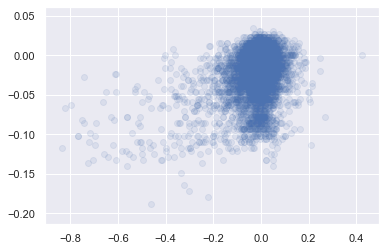

In [12]:
plt.scatter(y_tr, y_tr_pred, alpha=0.1)

In [13]:
print(pearsonr(y_tr, y_tr_pred))

(0.3435460676698574, 8.355150702882435e-242)


In [14]:
y_ts_pred = clf.predict(x_ts)

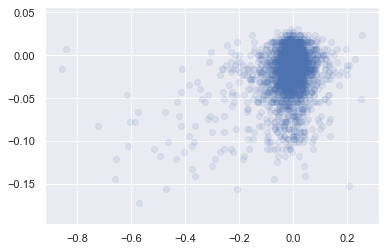

In [15]:
plt.scatter(y_ts, y_ts_pred, alpha=0.1)

In [16]:
print(pearsonr(y_ts, y_ts_pred))

(0.28419727129293615, 2.0234614748170603e-54)
